# Stats visualizations

This notebook ranks parameter configurations by test Kendall tau and visualizes validation losses across hyperparameters.

In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from approximate_centrality import DEFAULT_CONFIG

stats_path = Path("stats.json")
with stats_path.open() as f:
    stats = json.load(f)

df = pd.DataFrame(stats)

# Ensure consistent column order
hyperparams = ["embed_size", "num_layers", "num_folds", "num_epochs"]

print(f"Loaded {len(df)} configs from {stats_path}")

2026-02-09 12:54:50.770659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loaded 17 configs from stats.json


In [6]:
# 1) Rank parameter configs by test Kendall tau (top 10)
top10 = (
    df.sort_values(by="kendall_tau_test", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

cols = hyperparams + ["kendall_tau_test", "p_value_test", "kendall_tau_train", "p_value_train"]
print(top10[cols].to_string(index=False))

 embed_size  num_layers  num_folds  num_epochs  kendall_tau_test  p_value_test  kendall_tau_train  p_value_train
        256          16          5          10          0.523481  0.000000e+00           0.684351            0.0
        256           1          5          10          0.041798  6.258308e-11           0.643444            0.0
         64           5          5          10         -0.343122  0.000000e+00           0.668584            0.0
        256           5          5           5         -0.465130  0.000000e+00           0.651541            0.0
        256           5          5          10         -0.507161  0.000000e+00           0.669758            0.0
        256           5          5          10         -0.507660  0.000000e+00           0.672495            0.0
        256           5          5          10         -0.508741  0.000000e+00           0.668686            0.0
        256           4          5          10         -0.519408  0.000000e+00           0.66154

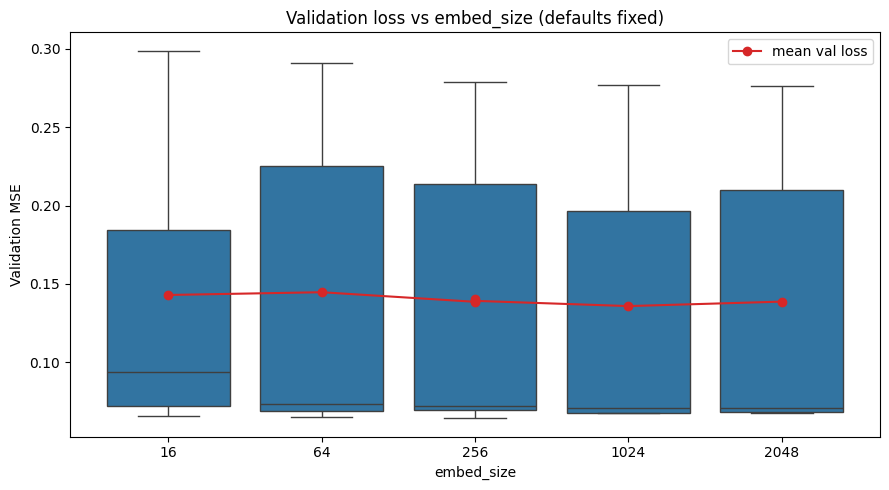

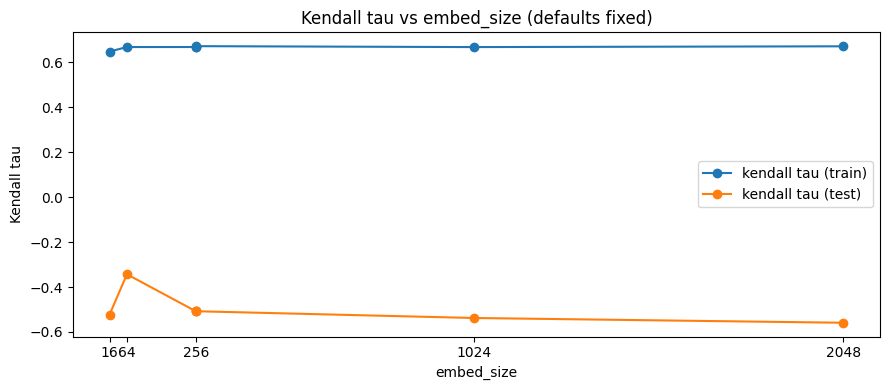

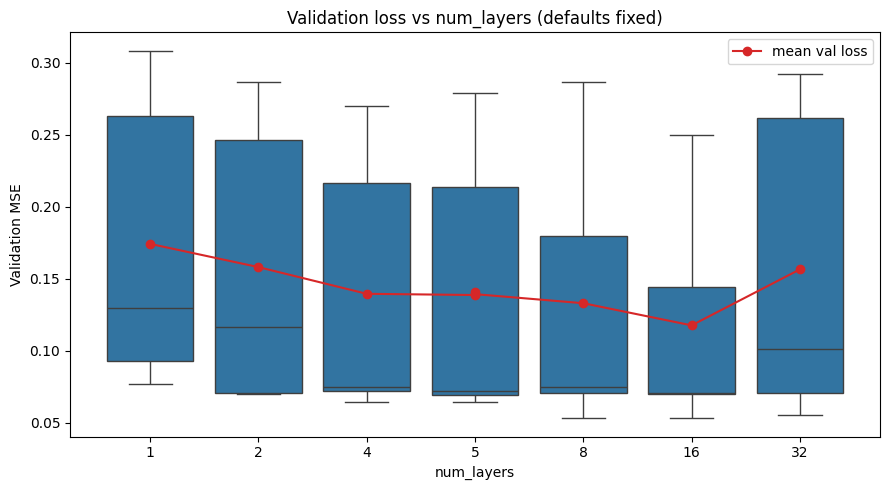

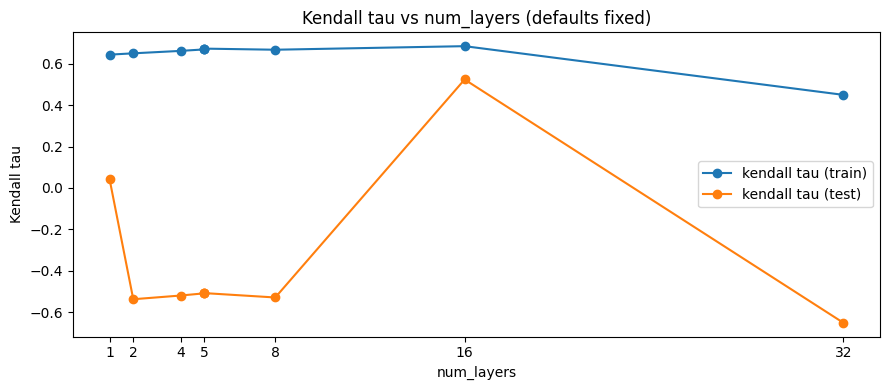

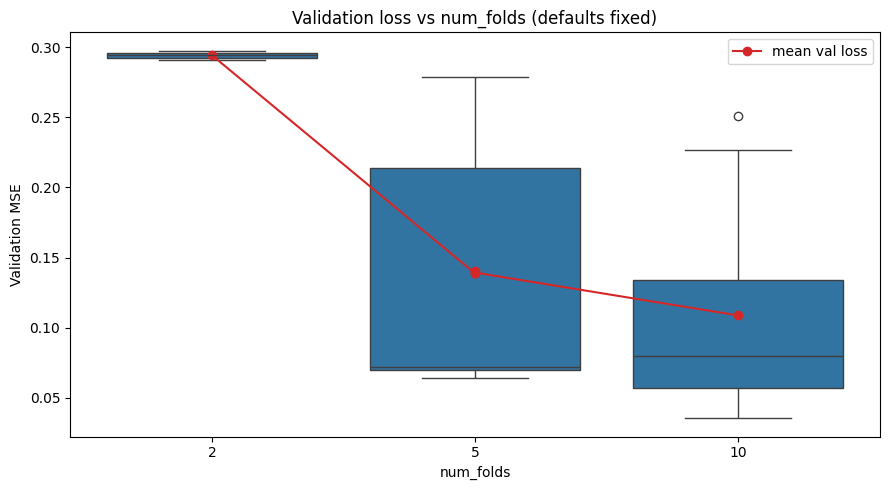

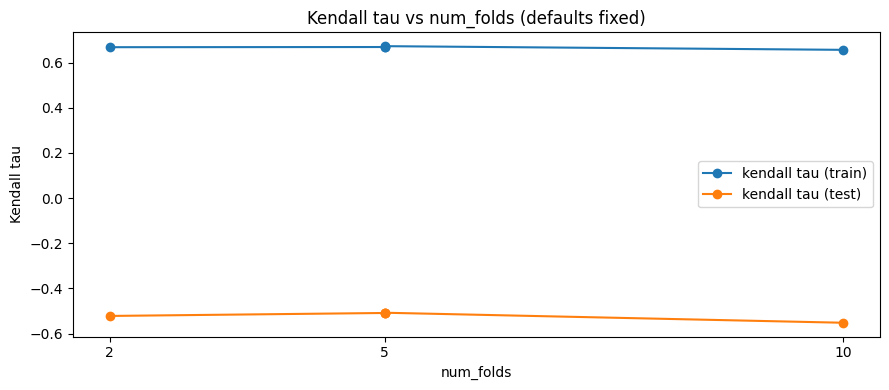

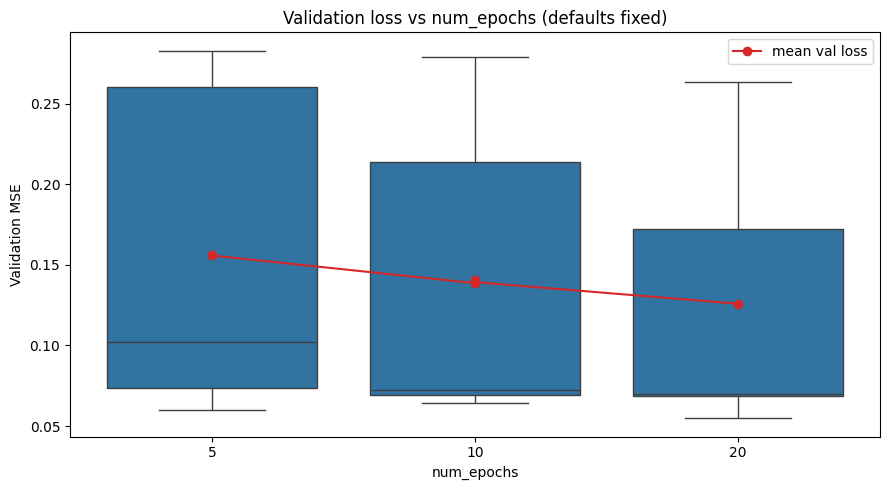

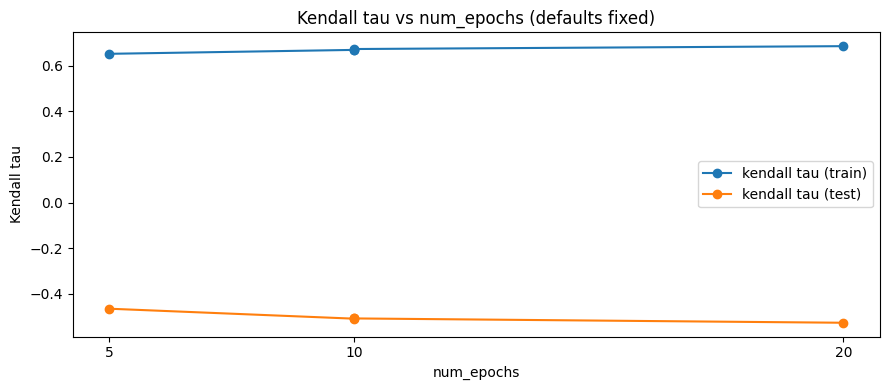

In [3]:
# 2) Validation loss and Kendall tau vs each hyperparameter

def plot_hyperparam_slices(df, hyperparam, default_config, loss_col="train_val_losses"):
    other_params = [p for p in hyperparams if p != hyperparam]

    # Keep configs that match the default on all other hyperparameters
    mask = np.ones(len(df), dtype=bool)
    for p in other_params:
        mask &= df[p] == default_config[p]
    slice_df = df[mask].copy()

    if slice_df.empty:
        print(f"No configs found for {hyperparam} with default settings.")
        return

    # Expand fold losses into long format for box plots
    records = []
    for _, row in slice_df.iterrows():
        for loss in row[loss_col]:
            records.append({
                hyperparam: row[hyperparam],
                "val_loss": loss,
            })
    long_df = pd.DataFrame(records)

    order = sorted(long_df[hyperparam].unique())
    x_pos = {v: i for i, v in enumerate(order)}

    # Aggregate mean loss per config for a line overlay
    mean_df = slice_df.copy()
    mean_df["mean_val_loss"] = mean_df[loss_col].apply(lambda xs: float(np.mean(xs)))
    mean_df = mean_df.sort_values(by=hyperparam)

    plt.figure(figsize=(9, 5))
    ax = sns.boxplot(data=long_df, x=hyperparam, y="val_loss", order=order)
    ax.plot(
        [x_pos[v] for v in mean_df[hyperparam]],
        mean_df["mean_val_loss"],
        marker="o",
        linewidth=1.5,
        color="tab:red",
        label="mean val loss",
    )
    ax.set_title(f"Validation loss vs {hyperparam} (defaults fixed)")
    ax.set_xlabel(hyperparam)
    ax.set_ylabel("Validation MSE")
    ax.set_xticks(range(len(order)))
    ax.set_xticklabels(order)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Kendall tau plots (train and test)
    plt.figure(figsize=(9, 4))
    ax = plt.gca()
    ax.plot(
        mean_df[hyperparam],
        mean_df["kendall_tau_train"],
        marker="o",
        linewidth=1.5,
        label="kendall tau (train)",
    )
    ax.plot(
        mean_df[hyperparam],
        mean_df["kendall_tau_test"],
        marker="o",
        linewidth=1.5,
        label="kendall tau (test)",
    )
    ax.set_title(f"Kendall tau vs {hyperparam} (defaults fixed)")
    ax.set_xlabel(hyperparam)
    ax.set_ylabel("Kendall tau")
    ax.set_xticks(order)
    ax.legend()
    plt.tight_layout()
    plt.show()


for hp in hyperparams:
    plot_hyperparam_slices(df, hp, DEFAULT_CONFIG)